# Cameras and Calibration

Kevin J. Walchko created 27 July 2017

----

Let's go over our first robotic sensor that we will use in this course. It is an important sensor and we will only have time to just scratch the surface. Computer vision is becoming more and more important every day. Understanding how cameras work, how to calibrate them, and how they could be used to recontruct our world virtually is important.

## Objectives

- understand how a camera works
- understand the pinhole camera model
- understand camera calibration
- understand how this applies to stereo vision

## References

- [OpenCV 3.3 Docs](http://docs.opencv.org/3.3.0/)
- [OpenCV 2.4 Camera Calibration](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [Scott's work - I can't find the link again](tbd)
- [skimage ransac library](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.ransac)

## Setup

In [1]:
%matplotlib inline 

In [2]:
from __future__ import print_function, division
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

<img src="./images/output-1.png" />

<img src="./images/output-2.png" />

<img src="./images/output-4.png" />

There are many military and scientific applications where filters are placed in front of an imager to detect different things based on their wavelength.

<img src="./images/output-5.png" />

- lenses made today generally allow the light rays to pass straight through without adversly affecting their path. However, depending on your application, you may need to calibrate your camera to produce a better picture. Stereo vision and video odometry are two such applications where sub pixel performance needs to be good in order to obtain good results.

<img src="./images/fstop.jpg" />

<img src="./images/output-6.png">

<img src="images/bayer.png">

- Some high end or scientific imaging systems use multiple image planes for each wavelenth (i.e., red, blue, green) they want to capture. These are generally rare
- Most cameras have only one image plane and they usually have color filters attached to each pixel in a Bayer arrangement. The classic bayer patter is one of several patters that companies have patented and implemented in camera systems
- Most imaging systems are sensative to IR light and in addition to a bayer pattern filter attached, they also have an IR filter attached so the camera is not washed out by ambient sunlight
    - A common way to produce a low light camera (like a baby monitor) is take a normal camera and remove the IR filter

<img src="./images/output-7.png" />

- In OpenCV, our images have a bit depth of 8b (unint8) which has a value of 0 - 255. 

<img src="./images/output-9.png" />

- Ok, maybe fake is a little over the top, but the idea is that our image is a heavily filtered, distorted, processed, quantized (0-255) view of the world. Depending on what you want to do with that, it might be ok!
- This is often the reason intelligence and scientific imagers are very expensive and take a long time to develop. They don't make the same compromises that commercial cameras/cellphones make.

# Basic

Now let's grab an image ... jupyter wasn't made for grabbing video, but later we can cheat a little and do it. Now depending on your camera, you might some of this info back or you might not. It just depends on the driver and if OpenCV can get the info.

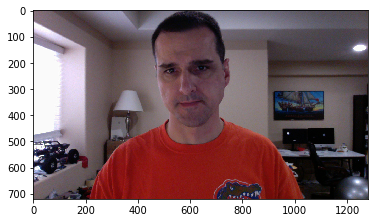

In [3]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)

cap.release()

In [3]:
# create a map to keep track of all these names
prop_map = {
    "pos_msec":cv2.CAP_PROP_POS_MSEC,
    "pos_frame":cv2.CAP_PROP_POS_FRAMES,
    "avi_ratio":cv2.CAP_PROP_POS_AVI_RATIO ,
    "width":cv2.CAP_PROP_FRAME_WIDTH ,
    "height":cv2.CAP_PROP_FRAME_HEIGHT ,
    "fps":cv2.CAP_PROP_FPS ,
    "fourcc":cv2.CAP_PROP_FOURCC ,
    "frame_count":cv2.CAP_PROP_FRAME_COUNT,
    "format":cv2.CAP_PROP_FORMAT ,
    "mode":cv2.CAP_PROP_MODE ,
    "brightness":cv2.CAP_PROP_BRIGHTNESS ,
    "contrast":cv2.CAP_PROP_CONTRAST ,
    "saturation":cv2.CAP_PROP_SATURATION,
    "hue":cv2.CAP_PROP_HUE ,
    "gain":cv2.CAP_PROP_GAIN ,
    "exposure":cv2.CAP_PROP_EXPOSURE ,
    "convert_rgb":cv2.CAP_PROP_CONVERT_RGB ,
 #   "white_balance":cv2.cv.CV_CAP_PROP_WHITE_BALANCE ,
    "rectification":cv2.CAP_PROP_RECTIFICATION}

# get a camera property
def get_prop(cam,name,prop_map):
    return cam.get(prop_map[name])

# set a camera property
def set_prop(cam,name,prop_map,value):
    cam.set(prop_map[name],value)

# print out all of the properites
def poll_props(cam,prop_map):
    out_map = {}
    for k,v in prop_map.items():
        result = cam.get(v)
        if( result == -1.0 ):
            out_map[k] = None
        else:
            out_map[k] = result
    return out_map

# create a camera and get its property
cam = cv2.VideoCapture(0)
properties = poll_props(cam,prop_map)

images = []

# list our properties
for k,v in properties.items():
    print("{0:<12}\t:{1:<12}".format(k,v))

# put our toys back on the shelf 
cam.release()

hue         	:0.0         
saturation  	:64.0        
format      	:None        
brightness  	:128.0       
pos_frame   	:None        
convert_rgb 	:None        
rectification	:None        
height      	:480.0       
contrast    	:32.0        
width       	:640.0       
pos_msec    	:None        
fps         	:0.0         
fourcc      	:844715353.0 
mode        	:None        
avi_ratio   	:None        
frame_count 	:None        
gain        	:128.0       
exposure    	:-6.0        


# Camera Model

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

![Pinhole Camera Model](images/pinhole_camera_model.png)

\begin{eqnarray}
  s p' = A[R|t]P' \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & 0 & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}

where:

- P(X, Y, Z) are the coordinates of a 3D point in the world coordinate space
- p(u, v) are the coordinates of the projection point in pixels
- A is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center
- fx, fy are the focal lengths expressed in pixel units
- [R|t] are the **extrinsic** parameters (think external parameters)

The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when $z \ne 0$ ):

\begin{eqnarray}
  \begin{bmatrix} x \\ y \\ z \end{bmatrix} = R_{3x3}
  \begin{bmatrix} X \\ Y \\ Z \end{bmatrix} + t_{xyz} \\
  x' = \frac{x}{z} \\
  y' = \frac{y}{z} \\
  u = f_x*x'+c_x \\
  v = f_y*y'+c_y
\end{eqnarray}

## Focal Length

![](images/focal-length.jpg)

The focal length of a camera is an important aspect for a couple of reasons.

1. A properly designed camera has a focal length which ensures your entire image plane is illuminated with light
1. Your focal length also determines your field of view.

$$
\alpha = 2 \cdot arctan2(w, 2f) \\
f = \frac{w}{2} \cot( \frac{\alpha}{2} )
$$

A lot of cameras have a fixed focal length, like our cell phone camera used with the raspberry pi, but some cameras have a mechanical zoom feature which narrows the FOV and allow more pixels across a smaller area.

All cameras have a digital zoom, where they smartly average pixels together to simulate a mechanical zoom, but it really isn't a zoom. You are better off taking the native image and then "zooming" and cropping the image in software later.

## Distortions

If everything was perfect, the red lines in the image below would lie neatly on the checkerboard.

![](images/distortion.jpg)

However, there are always little distortions in the lense (or misalignments) that break this model. Typically you must correct for radial ($k_{1-6}$) and tangential ($p_{1-2}$) distortions coefficients which effect the $x'$ and $y'$ terms in a nonlinear manor. The pictures below show the barrel distortion (typically $k_1 > 0$) and pincushion distortion (typically $k_1 < 0$).

![](images/distortion_examples.png)

## Calibration

So how do we do this? The calibration code for the checkerboard does:

1. Converts image to grayscale
2. Searches for the intersections of the chessboard and should find 9x6 of them (i.e., 54 intersections)
3. Using homography and knowing that we are using a chessboard, it then uses an algorithm, typically RANSAC, to figure out the how the calibration target was warped in order to match the image.
    1. Note, there are other camera targets besides the classic chessboard. 
4. It then returns your calculated camera matrix and distortion parameters (the k's mentioned above) which allow you to remove distortion from an image

## OpenCV Calibration

OpenCV supports calibrating cameras based off a couple of patterns:

<span>
  <img src="images/checkerboard.jpg" width="30%"> 
  <img src="images/symetric-circles.jpg" width="30%"> 
  <img src="images/asymetric-circles.jpg" width="30%">  
</span>

# RANSAC

Fit a model to data with the RANSAC (random sample consensus) algorithm. RANSAC is an iterative algorithm for the robust estimation of parameters from a subset of inliers from the complete data set. Each iteration performs the following tasks:

1. Select min_samples random samples from the original data and check whether the set of data is valid (see is_data_valid).
1. Estimate a model to the random subset (model_cls.estimate(*data[random_subset]) and check whether the estimated model is valid (see is_model_valid).
1. Classify all data as inliers or outliers by calculating the residuals to the estimated model (model_cls.residuals(*data)) - all data samples with residuals smaller than the residual_threshold are considered as inliers.
1. Save estimated model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has less sum of residuals.

Here is an example:

![](images/cal-images.jpg)

Ultimately we find 2 things from calibration: 

1. Camera matrix
1. Distortion coefficients

An example output from the OpenCV process, saved as [XML](https://www.w3.org/XML/) or alternatively as [YAML](http://yaml.org/) file:

    <Camera_Matrix type_id="opencv-matrix">
    <rows>3</rows>
    <cols>3</cols>
    <dt>d</dt>
    <data>
     6.5746697944293521e+002 0. 3.1950000000000000e+002 0.
     6.5746697944293521e+002 2.3950000000000000e+002 0. 0. 1.</data></Camera_Matrix>
    <Distortion_Coefficients type_id="opencv-matrix">
    <rows>5</rows>
    <cols>1</cols>
    <dt>d</dt>
    <data>
     -4.1802327176423804e-001 5.0715244063187526e-001 0. 0.
     -5.7843597214487474e-001</data></Distortion_Coefficients>

where the camera matrix again is:

$$
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$

So here, we get:

- focal length: 657.5, 657.5 px
- center: 319.5, 239.5 px
- distortion coefficients: -0.418, 0.507, 0, 0, -0.578

Let's do an example

In [4]:
import opencvutils as cvu
from opencvutils.CameraCalibrate import CameraCalibration
print('OpenCV version {}'.format(cvu.get_opencv_version()))
import glob

<<< WARNING: using fake raspberry pi interfaces >>>
<<< Using: <class 'fake_rpi.RPi._GPIO'> >>>
OpenCV version (3, 3, 1)


In [5]:
calibration_images = 'cal_images/left*.jpg'
images = []
images = glob.glob(calibration_images)

In [6]:
# create a calibration instance called cal
cal = CameraCalibration()

# the pattern is a classic checkerboard
cal.marker_checkerboard = True

# calibrate using the images and the 9x6 checkerboard
# Note: 9x6 refers to the intersections, not the boxes
mat = cal.calibrate(images, alpha=1.0, marker_size=(9, 6))
cv2.destroyAllWindows()

[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners
[+] found  54 of 54 corners


The resulting camera info shows a low level of distortion, so the effect with and without the correction will be small to the human eye. However, for computer vision work, it could make a difference.

If we print out the camera matrix:

In [7]:
cal.printMatrix()

focal length 532.8 532.9
image center 342.5 233.9
radial distortion -0.281 0.027
tangental distortion 0.001 -0.000
RMS error: 0.196437908903


## Undistort Image

Now let's read back in an image and use the calibration matrix to undistort it.

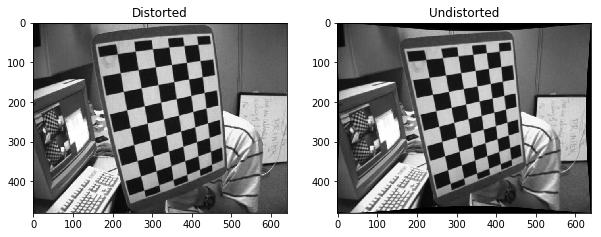

In [8]:
# read in a grayscale image
image = cv2.imread(images[12], 0)
dst = cal.undistort(image)

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray');
plt.title('Distorted')

plt.subplot(1,2,2)
plt.imshow(dst, cmap='gray');
plt.title('Undistorted');

Hopefully you can see the warping in the middle of the image is gone in the right side. Cameras are made much better now, than they use to be, so for a lot of single camera applications this is not necessary. However, for stereo vision (2 or more cameras) or some of the 3D work, it is necessary to calibrate your cameras.

# Stereo Vision

![](images/stereo_frames.png)

Now we won't go into stereo vision too much, it is really complicated to get it to work right all the time, but we'll show a simple example. The same idea we had before for the camera model can be expanded to 2 or more cameras.

With a normal, single camera we cannot determine depth. However, if we have a second camera, we can now calculate depth. Looking at the left image plane, point x lines along a line in 3D space we cannot measure with a single camera. However, with a second camera, that line cuts across it's image plane to form a line. This line in the right image plane is called an **epiline** which means, to find the point x on the right image, search along this epiline. Think of it this way, to find the matching point in other image, you need not search the whole image, just search along the epiline which will provide better performance and accuracy.  This is called **Epipolar Constraint**. Similarly all points will have its corresponding epilines in the other image. 

![](stereo/epipolar.jpg)

Now, generally, the 2 camera frames are located side-by-side. we also need both camera's to be calibrated, so straight lines are straight (don't want our epilines to be curved or messed up). We also need to understand the distance between each camera, called the baseline. Unfortunately, the calibration, orientation of the cameras (think mounting of the cameras to something), and distance between them has to be very accurate. Otherwise the math to calculate disparity (or reconstruct where things are in 3D space) will not work correctly.

We need a couple of things to make this work.

- **Essential Matrix (E):** contains the information about translation and rotation between the 2 cameras in global coordinates.
- **Fundamental Matrix (F):** contains the same information as E, but also contains intrinsics of both cameras so that we can relate the two cameras in pixel coordinates.

Now, as long as both cameras are calibrated (meaning they produce rectified images) and we normalize the points we are trying to match by the focal length, then, F = E. In simple words, Fundamental Matrix F, maps a point in one image to a line (epiline) in the other image. This is calculated from matching points from both the images. A minimum of 8 such points are required to find the fundamental matrix (while using [8-point algorithm](https://en.wikipedia.org/wiki/Eight-point_algorithm)). More points are preferred and use RANSAC to get a more robust result.

![](stereo/essential_matrix.jpg)

Now the diagram above shows the image planes rotated in for effect, but typically they are not. Frames that are perfectly aligned with the world and each other have an ideal matrix like: 

![](images/stereo_matrix.png)

Realistically though, there will be some rotation between them and misalignment such that there are more terms.

Now that we have our cameras all calibrated and we understand the alignment between them. The basic idea of calculating the disparity is:

![](images/stereo_depth.jpg)

which leads to $disparity = x - x' = \frac{Bf}{Z}$ where B is the baseline (shown as T above, sorry) and Z is the distance from the camera. Note, disparity is **not** the position in the world **unless** the world's origin is at the camera location (which is highly unlikely).

Also, algorithms that try to find stereo matches and calculate the disparity need calibrated cameras so that straight lines appear straight in the image. A common technique is to find key points in one image and then look in the second image alone the same row for the same key point. If the camera image is distorted, then key points won't appear where they are expected and the algorithm won't be able to calculate disparity.

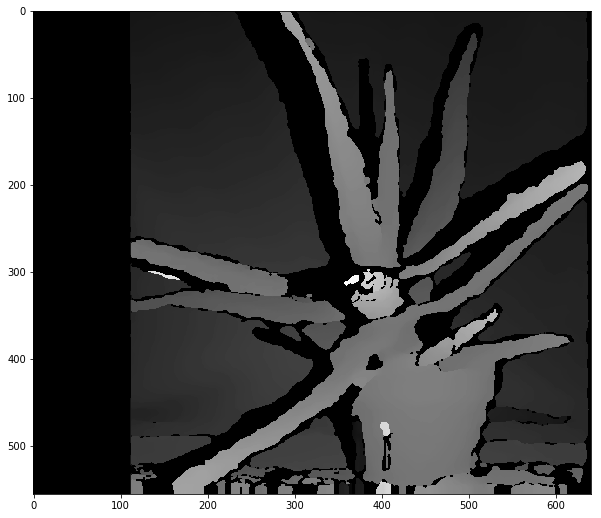

In [9]:
# we are using rectified images
imgL = cv2.pyrDown( cv2.imread('stereo/aloeL.jpg') )
imgR = cv2.pyrDown( cv2.imread('stereo/aloeR.jpg') )

# disparity range is tuned for 'aloe' image pair
# see the help for better understanding of these parameters
window_size = 3
min_disp = 16
num_disp = 112-min_disp
stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
   numDisparities = num_disp, # Maximum disparity minus minimum disparity
   blockSize = 16,
   P1 = 8*3*window_size**2,  # parameters for disparity matching
   P2 = 32*3*window_size**2,
   disp12MaxDiff = 1,  # matching differences
   uniquenessRatio = 10,  # matching parameter
   speckleWindowSize = 100,  # filtering to remove speckles in an image
   speckleRange = 32
)

disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray');

# Questions

1. What are the equations to go from world to pixel coordinates according to the pinhold camera model?
1. What are the steps of camera calibration?
1. The calibration process returns 2 things, what are they and how are they useful?
1. What are intrinsic and extrinsic parameters?
1. Given 2 images, identify which image is distorted by pincushion distortion and which image is distorted by barrel distortion
1. What is the focal length of a camera mean?
1. What is the Bayer pattern and why do we use it?
1. In the Bayer pattern, which color is most common and why?
1. In stereo vision, what is meant by disparity and camera baseline?
1. What type of calibration targets are available to use in OpenCV?
1. Why is calibrating a camera important?


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.